In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the original dataset
df = pd.read_csv('inventory_data.csv')
df.head()

,Date,Item_ID,Item_Type,Item_Name,Current_Stock,Min_Required,Max_Capacity,Unit_Cost,Avg_Usage_Per_Day,Restock_Lead_Time,Vendor_ID
0,2024-10-01,105,Consumable,Ventilator,1542,264,1018,4467.55,108,17,V001
1,2024-10-02,100,Equipment,Ventilator,2487,656,3556,5832.29,55,12,V001
2,2024-10-03,103,Equipment,Surgical Mask,2371,384,5562,16062.98,470,6,V001
3,2024-10-04,103,Consumable,Surgical Mask,2038,438,1131,744.10,207,15,V002
4,2024-10-05,107,Equipment,IV Drip,2410,338,1013,15426.53,158,12,V003


As this dataset has some logical errors in some of it's columns, I had to execlude any feature with errors in it's values and try to make benefits from what is left.


In [4]:
df.drop(columns=['Item_ID' , 'Item_Type' , 'Item_Name' , 'Max_Capacity' , 'Unit_Cost' , 'Vendor_ID'], inplace = True)

df.head()

,Date,Current_Stock,Min_Required,Avg_Usage_Per_Day,Restock_Lead_Time
0,2024-10-01,1542,264,108,17
1,2024-10-02,2487,656,55,12
2,2024-10-03,2371,384,470,6
3,2024-10-04,2038,438,207,15
4,2024-10-05,2410,338,158,12


I'll use these features to predict a shortage risk for different items. So, I can create shortage column by clustering this dataset or there is another way, faster and more simple, based on reorder-point equation which is  based on EOQ (Economic Order Quantity) calculation.

Reorder-Point = ( AVG-usage-per-day  *  Restock-lead-time ) + ( Min-required  \  2 )

In [5]:
# Create Reorder-Point feature:-
df['Reorder_Point'] = (df['Avg_Usage_Per_Day'] * df['Restock_Lead_Time']) + (df['Min_Required'] / 2)

In [6]:
# Create binary target: 1 = shortage risk, 0 = safe
df['Shortage_Risk'] = (df['Current_Stock'] < df['Reorder_Point']).astype(int)

In [7]:
# Check results
df[['Current_Stock', 'Reorder_Point', 'Shortage_Risk']].head()

,Current_Stock,Reorder_Point,Shortage_Risk
0,1542,1968.0,1
1,2487,988.0,0
2,2371,3012.0,1
3,2038,3324.0,1
4,2410,2065.0,0


In [9]:
# Count the occurrences of each category in the 'Shortage_Risk' column
Shortage_Risk_counts = df['Shortage_Risk'].value_counts()

Shortage_Risk_counts

Shortage_Risk
1    320
0    180
Name: count, dtype: int64

In [10]:
# Features and target
X = df[['Reorder_Point', 'Current_Stock']]
y = df['Shortage_Risk']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [11]:
# Initialize models
logreg = LogisticRegression(class_weight='balanced')
tree = DecisionTreeClassifier(max_depth=2, random_state=42)
forest = RandomForestClassifier(n_estimators=50, max_depth=2, random_state=42)

# Fit the models
logreg.fit(X_train, y_train)
tree.fit(X_train, y_train)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, n_estimators=50, random_state=42)

In [12]:
def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))

evaluate_model(logreg, "Logistic Regression")
evaluate_model(tree, "Decision Tree (depth=2)")
evaluate_model(forest, "Random Forest (depth=2)")


Logistic Regression
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0

Decision Tree (depth=2)
Accuracy: 0.912
Precision: 0.896551724137931
Recall: 0.975
F1 Score: 0.9341317365269461
ROC AUC: 0.9397222222222222

Random Forest (depth=2)
Accuracy: 0.912
Precision: 0.896551724137931
Recall: 0.975
F1 Score: 0.9341317365269461
ROC AUC: 0.9897222222222222


In [14]:
# Test for Overfitting

# Evaluate on training data
evaluate_model(logreg, "Logistic Regression - Training")


Logistic Regression - Training
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0


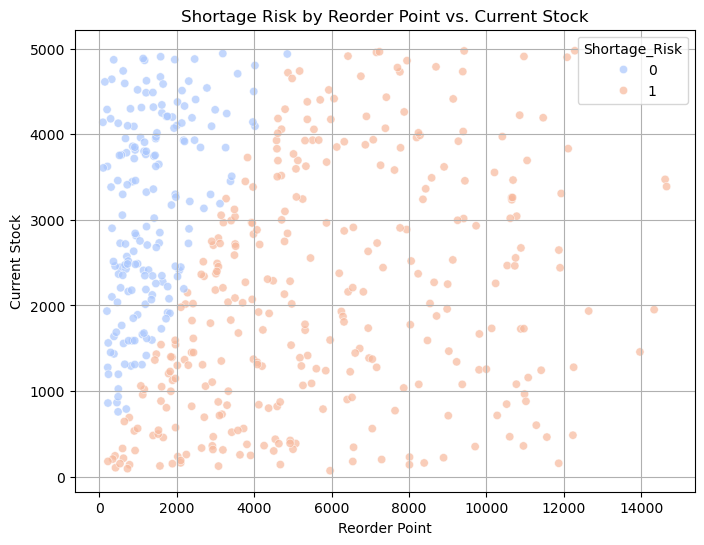

In [15]:
# Visualize the Data Separation

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Reorder_Point', y='Current_Stock', hue='Shortage_Risk', palette='coolwarm', alpha=0.7)
plt.title('Shortage Risk by Reorder Point vs. Current Stock')
plt.xlabel('Reorder Point')
plt.ylabel('Current Stock')
plt.grid(True)
plt.show()

As training and testing performance are both perfect and the data is linearly separable, Logistic Regression is the best, simplest, most explainable choice.
No need for more complex models like Random Forest in this case.

In [16]:
import joblib

# Save the model to a file
joblib.dump(logreg, 'shortage_risk_logistic_model.pkl')

['shortage_risk_logistic_model.pkl']